# Sorting Algorithm Visualizer

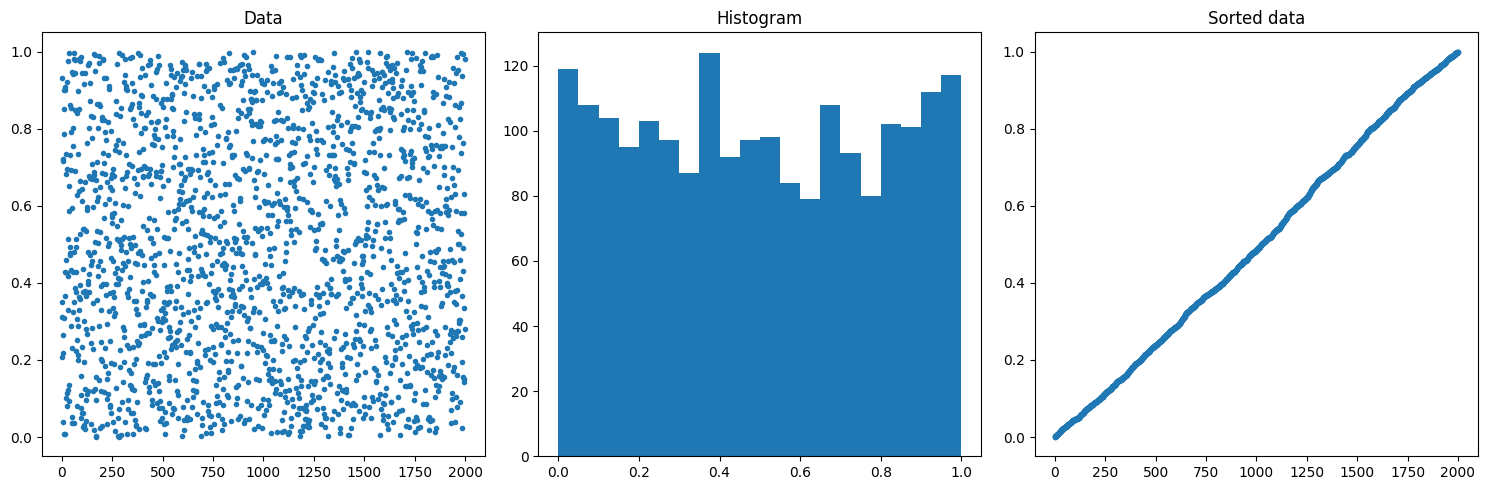

In [277]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation

"""
    Data generation mode:
        random: completely random, no correlation between the data
        many_same: many data points are the same. Lower data coefficient means less data points are the same
    Data coefficient: Parameter for datan generation mode
    Random data points: number of data points to generate
    Random min value: minimum value for random data generation
    Random max value: maximum value for random data generation
    Shuffle before: shuffle the data before plotting
"""
data_generation_mode = "random"
data_coefficient = 0.01
random_data_points = 2000
random_min_value = 0
random_max_value = 1
shuffle_before = True

if data_generation_mode == "random":
    data = np.random.uniform(random_min_value, random_max_value, random_data_points)
elif data_generation_mode == "many_same":
    same_data_points = data_coefficient * random_data_points
    unique_data = np.random.uniform(random_min_value, random_max_value, int(random_data_points//same_data_points))
    data = np.repeat(unique_data, same_data_points)
elif data_generation_mode == "gaussian":
    data = np.random.normal(0, data_coefficient, random_data_points)

# Normalize data from 0 to 1
data = random_min_value + random_max_value*(data - np.min(data)) / (np.max(data) - np.min(data))

if shuffle_before:
    np.random.shuffle(data)

fig, (ax1,ax2,ax3) = plt.subplots(1,3, figsize=(15,5))
ax1.plot(data, '.')
ax1.set_title("Data")
ax2.hist(data, bins=20)
ax2.set_title("Histogram")
ax3.plot(np.sort(data), '.')
ax3.set_title("Sorted data")
plt.tight_layout()


# Sorting Algorithm Implementations

All loops are completely unfolded, meaning we can see every single operation that is executed.

In [279]:
# Template Class for sorting algorithms
class BaseSort:
    def __init__(self, data):
        self.data = np.copy(data)
        self.data_length = len(data)
        self.sorted_data = np.copy(data)
        self.pre_sorted_data = np.sort(data)
        self.comparisons = 0
        self.swaps = 0
        self.iterations = 0
        self.is_sorted = False
        self.pointer = [0]
        self.name = "base"
        self.artists: list = []

    def swap(self, i, j):
        self.sorted_data[i], self.sorted_data[j] = self.sorted_data[j], self.sorted_data[i]
        self.swaps += 1

    def compare(self, i, j):
        self.comparisons += 1
        return self.sorted_data[i] <= self.sorted_data[j]

    def iterate(self):
        self.iterations += 1

    def plot(self, ax):
        artist = ax.plot(self.sorted_data, '.', color='C0')
        ax.set_title(f"{self.__class__.__name__} - {self.comparisons} comparisons - {self.swaps} swaps")
        artists = [ax.plot([p, p], [0, self.sorted_data[p]]) for p in self.pointer if p < self.data_length and p >= 0]
        self.artists = [artist] + artists
        ax.set_xlim(0, self.data_length)
        return self.artists

    def updatePlot(self, artists = None):
        if artists is None:
            artists = self.artists
        artists[0][0].set_ydata(self.sorted_data)
        for i,p in enumerate(self.pointer,start=1):
            if p < self.data_length and p > 0:
                artists[i][0].set_xdata([p, p])
                artists[i][0].set_ydata([0, self.sorted_data[p]])

    def isSorted(self):
        self.is_sorted = np.all(self.sorted_data == self.pre_sorted_data)
        return self.is_sorted
    
    def reset(self):
        self.sorted_data = np.copy(self.data)
        self.comparisons = 0
        self.swaps = 0
        self.iterations = 0
        self.pointer = [0 for p in self.pointer]
        self.is_sorted = False

    def getStrState(self):
        return f"{self.name} - {self.comparisons} comparisons - {self.swaps} swaps"
    
    def disablePointers(self, artists = None):
        if artists is None:
            artists = self.artists
        for i,p in enumerate(self.pointer,start=1):
            artists[i][0].set_xdata([-5, -5])
            artists[i][0].set_ydata([0, 0])
        self.pointer = [-5 for p in self.pointer]

# Bubble Sort
class BubbleSort(BaseSort):
    def __init__(self, data):
        super().__init__(data)
        self.name = "bubble_sort"

    # Iterate Bubble Sort
    def iterate(self):
        super().iterate()
        if self.compare(self.pointer[0] + 1, self.pointer[0]):
            self.swap(self.pointer[0], self.pointer[0] + 1)
        self.pointer[0] += 1
        if self.pointer[0] > self.data_length-2:
            self.pointer[0] = 0

# Selection Sort
class SelectionSort(BaseSort):
    def __init__(self, data):
        super().__init__(data)
        self.name = "selection_sort"
        self.pointer = [0, 1, 0] # Pointer, Compare, Min

    # Iterate Selection Sort
    def iterate(self):
        super().iterate()
        if self.pointer[0] >= self.data_length or self.pointer[2] >= self.data_length:
            self.pointer[0] = 0
            self.pointer[1] = 1
            self.pointer[2] = 0
        if self.pointer[1] < self.data_length:
            if self.compare(self.pointer[1], self.pointer[2]):
                self.pointer[2] = self.pointer[1]
            self.pointer[1] += 1
        else:
            self.swap(self.pointer[0], self.pointer[2])
            self.pointer[0] += 1
            self.pointer[1] = self.pointer[0] + 1
            self.pointer[2] = self.pointer[0]

    def reset(self):
        super().reset()
        self.pointer = [0, 1, 0]

# Bidirectional Bubble Sort = Cocktail Shaker Sort
class CocktailShakerSort(BaseSort):
    def __init__(self, data):
        super().__init__(data)
        self.pointer = [0, 0, self.data_length-1] # Current, Min, Max
        self.mode = 0
        self.name = "cocktail_shaker_sort"

    # Iterate Cocktail Shaker Sort
    def iterate(self):
        super().iterate()
        # Going Right
        if self.mode == 0:
            if self.pointer[0] < self.pointer[2]:
                if self.compare( self.pointer[0] + 1, self.pointer[0] ):
                    self.swap( self.pointer[0], self.pointer[0] + 1 )
                self.pointer[0] += 1
            else:
                self.pointer[2] -= 1
                self.mode = 1
        # Going Left
        elif self.mode == 1:
            if self.pointer[0] > self.pointer[1]:
                if not self.compare(self.pointer[0] - 1, self.pointer[0]):
                    self.swap(self.pointer[0], self.pointer[0] - 1)
                self.pointer[0] -= 1
            else:
                self.pointer[1] += 1
                self.mode = 0

    def getStrState(self):
        return f"{self.name} - {self.comparisons} comparisons - {self.swaps} swaps - {self.mode} mode"

    def reset(self):
        super().reset()
        self.pointer = [0, 0, self.data_length-1]
        self.mode = 0

# Insertion Sort
class InsertionSort(BaseSort):
    def __init__(self, data):
        super().__init__(data)
        self.pointer = [1, 0]
        self.name = "insertion_sort"

    # Iterate Insertion Sort
    def iterate(self):
        super().iterate()
        if self.pointer[0] >= self.data_length:
            self.pointer[0] = 1
            self.pointer[1] = 0
        if self.pointer[1] >= 0 and self.compare(self.pointer[0], self.pointer[1]):
            self.swap(self.pointer[0], self.pointer[1])
            self.pointer[0] -= 1
            self.pointer[1] = self.pointer[0] - 1
        else:
            self.pointer[0] += 1
            self.pointer[1] = self.pointer[0] - 1

# Comb sort
class CombSort(BaseSort):
    def __init__(self, data):
        super().__init__(data)
        self.gap = self.data_length-1
        self.pointer = [0,self.gap]  # Current, Gap
        self.shrink = 1.3
        self.name = "comb_sort"

    # Iterate Comb Sort
    def iterate(self):
        super().iterate()
        self.pointer[1] = self.pointer[0] + self.gap
        if self.pointer[1] < self.data_length:
            if self.compare(self.pointer[1], self.pointer[0]):
                self.swap(self.pointer[0], self.pointer[1])
        self.pointer[0] += 1
        if self.pointer[0] >= self.data_length - self.gap:
            self.pointer[0] = 0
            self.gap = int(self.gap / self.shrink)
            if self.gap < 1:
                self.gap = 1

    def reset(self):
        super().reset()
        self.gap = self.data_length
        self.pointer = [0,self.gap]

# Quick Sort
class QuickSort(BaseSort):
    def __init__(self, data):
        super().__init__(data)
        self.pointer = [0, self.data_length-1, 0, 0]  # Left, Right, Index i, Index j
        self.pivot = 0
        self.mode = 0
        self.name = "quick_sort"
        self.stack = []

    def iterate(self):
        super().iterate()
        
        if self.mode == 0:
            if self.pointer[0] < self.pointer[1]:
                self.pivot = self.sorted_data[self.pointer[1]]
                self.pointer[2] = self.pointer[0]
                self.pointer[3] = self.pointer[0]
                self.mode = 1
            else:
                self.mode = 2
        if self.mode == 1:
            if self.pointer[3] < self.pointer[1]:
                self.comparisons += 1
                if self.sorted_data[self.pointer[3]] < self.pivot:
                    self.swap(self.pointer[2], self.pointer[3])
                    self.pointer[2] += 1
                    self.comparisons += 1
                self.pointer[3] += 1
            else:
                self.swap(self.pointer[2], self.pointer[1])
                self.stack.append((self.pointer[0], self.pointer[2]-1))
                self.stack.append((self.pointer[2]+1, self.pointer[1]))
                self.pointer[0] = self.pointer[2]+1
                self.pointer[1] = self.stack.pop()[1]
                self.mode = 0
        if self.mode == 2:
            if len(self.stack) > 0:
                self.pointer[0], self.pointer[1] = self.stack.pop()
            else:
                self.pointer[0] = self.data_length
            self.mode = 0

    def reset(self):
        super().reset()
        self.pointer = [0, self.data_length-1, 0, 0]
        self.stack = []
        self.mode = 0
    
    def getStrState(self):
        return f"{self.name} - {self.comparisons} comparisons - {self.swaps} swaps - {self.mode} mode - stack size {len(self.stack)}"

class BogoSort(BaseSort):
    def __init__(self, data):
        super().__init__(data)
        self.name = "bogo_sort"
        self.pointer = []

    def iterate(self):
        super().iterate()
        np.random.shuffle(self.sorted_data)

    def reset(self):
        super().reset()
        self.pointer = []

Frames Required: 3880104, Absolute Frames: 1440 -> Frame Skip is 3233
Fancy Animation Frames: 120, Fancy Animation Skip: 16
Frames Required: 2000999, Absolute Frames: 1440 -> Frame Skip is 1667
Fancy Animation Frames: 120, Fancy Animation Skip: 16
Frames Required: 1513908, Absolute Frames: 1440 -> Frame Skip is 1261
Fancy Animation Frames: 120, Fancy Animation Skip: 16
Frames Required: 1989621, Absolute Frames: 1440 -> Frame Skip is 1658
Fancy Animation Frames: 120, Fancy Animation Skip: 16
Frames Required: 51005, Absolute Frames: 1454 -> Frame Skip is 42
Fancy Animation Frames: 120, Fancy Animation Skip: 16
Frames Required: 26849, Absolute Frames: 1460 -> Frame Skip is 22
Fancy Animation Frames: 120, Fancy Animation Skip: 16


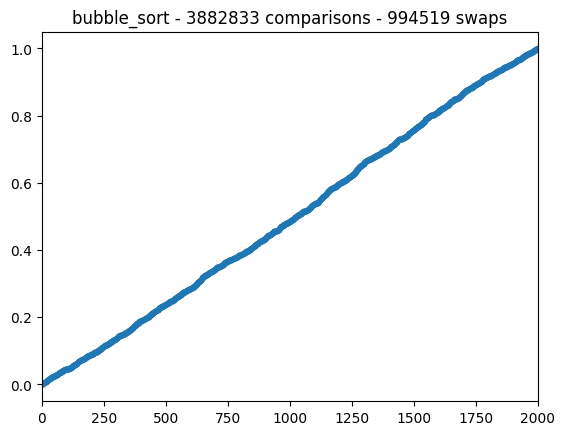

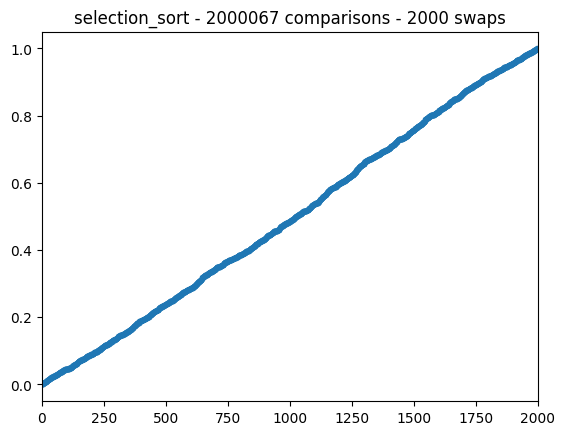

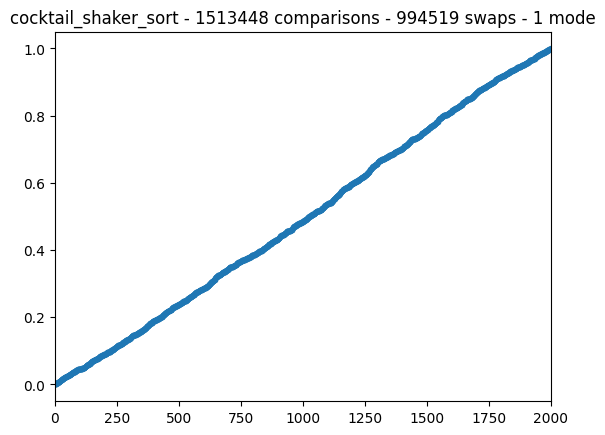

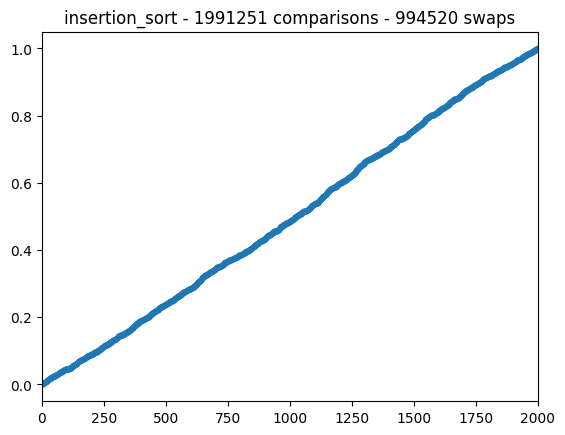

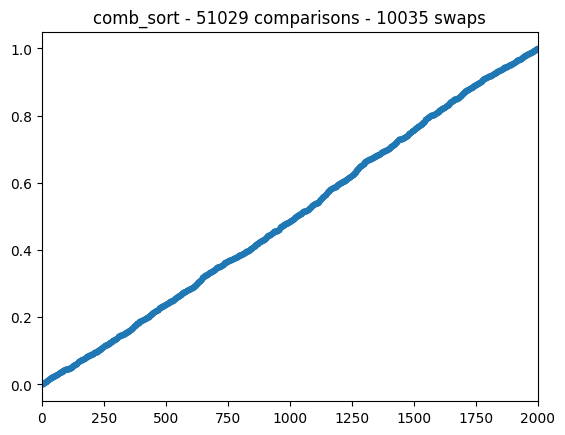

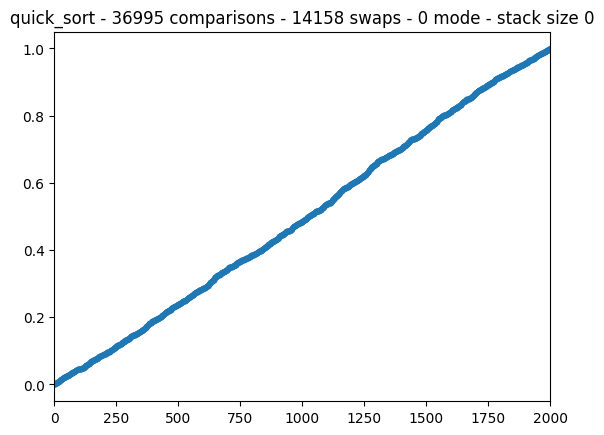

In [280]:
fps = 60
plot_time = 20 # s
final_result_time = 2 # s

def animate(sorter):
    fig, ax = plt.subplots()
    sorter.plot(ax)

    # Precalculate all frames
    while not sorter.isSorted() and sorter.iterations < random_data_points**2:
        sorter.iterate()
        #print(f"1. Comparisons: {sorter.comparisons}, Swaps: {sorter.swaps}", end='\r')


    total_frames = sorter.iterations
    sorter.reset()

    # The total frames required are the rendering frames // skip, plus some final waiting time plus the time for the fancy animation (random_data_points)
    frame_skip = max(1, total_frames//(fps*plot_time))
    fancy_animation_frames = min(final_result_time*fps, random_data_points)
    fancy_animation_skip = max(1, random_data_points // fancy_animation_frames)
    absolute_frames = total_frames // frame_skip + final_result_time*fps + fancy_animation_frames
    print(f"Frames Required: {total_frames}, Absolute Frames: {absolute_frames} -> Frame Skip is {frame_skip}")
    print(f"Fancy Animation Frames: {fancy_animation_frames}, Fancy Animation Skip: {fancy_animation_skip}")

    def update(frame):
        # Do fancy index animation
        frame_index_fancy = frame - total_frames // frame_skip
        frame_index_final = frame - total_frames // frame_skip - fancy_animation_frames
        if frame_index_fancy > 0:
            x = min(frame_index_fancy*fancy_animation_skip, random_data_points - 1)
            sorter.pointer = [x+i for i in range(len(sorter.pointer))]
        if frame_index_final > 0 and frame_index_fancy*fancy_animation_skip >= random_data_points - 1:
            sorter.disablePointers()
        elif frame_index_fancy < 0:
            for _ in range(frame_skip):
                sorter.iterate()
        ax.set_title(sorter.getStrState())
        print(f"2. Animation Progress {frame}/{absolute_frames}", end='\r')
        sorter.updatePlot()

    ani = animation.FuncAnimation(fig, update, frames=absolute_frames)
    ani.save(f"{sorter.name}_{data_generation_mode}_p{random_data_points}.mp4", fps=fps)

#sorter = QuickSort(data)
#animate(sorter)

for sorter in [BubbleSort(data), SelectionSort(data), CocktailShakerSort(data), InsertionSort(data), CombSort(data), QuickSort(data) ]:
    animate(sorter)